<a href="https://colab.research.google.com/github/TiffanyIzzuddin/eye-training-/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [ ]:
!git clone https://github.com/TiffanyIzzuddin/eye-disease-dataset.git

!ls eye-disease-dataset/dataset

Cloning into 'eye-disease-dataset'...
remote: Enumerating objects: 4245, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 4245 (delta 5), reused 0 (delta 0), pack-reused 4227 (from 2)
Receiving objects: 100% (4245/4245), 734.92 MiB | 16.14 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (4219/4219), done.
cataract  diabetic_retinopathy	glaucoma  normal


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
from sklearn.metrics import confusion_matrix # Import confusion_matrix


In [ ]:
from tensorflow.keras.applications import EfficientNetB0  # import EfficientNet
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
data_dir = 'eye-disease-dataset/dataset' # Changed the path to include the cloned repository name
for folder in os.listdir(data_dir):
  folder_path = os.path.join(data_dir, folder)
  if os.path.isdir(folder_path):
    num_files = len(os.listdir(folder_path))
    print(f"Folder '{folder}' contains {num_files} files.")

Folder 'glaucoma' contains 1007 files.
Folder 'diabetic_retinopathy' contains 1098 files.
Folder 'cataract' contains 1038 files.
Folder 'normal' contains 1074 files.


Displaying images from class: glaucoma


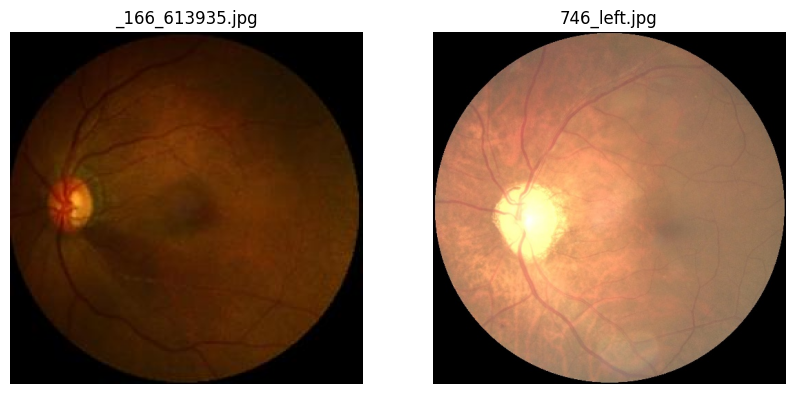

Displaying images from class: diabetic_retinopathy


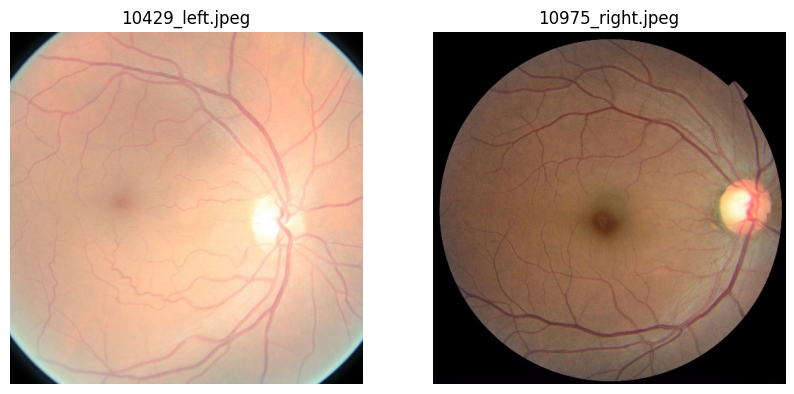

Displaying images from class: cataract


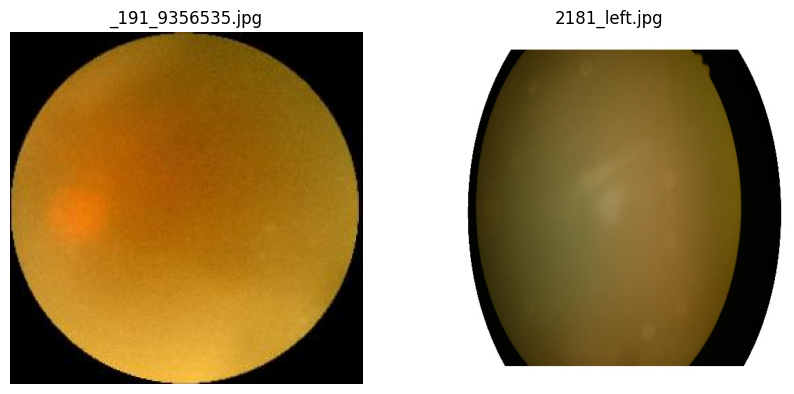

Displaying images from class: normal


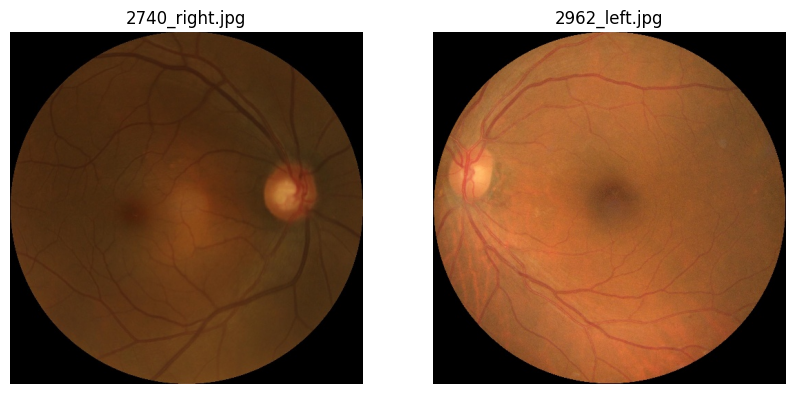

In [ ]:
import matplotlib.pyplot as plt
import os

data_dir = 'eye-disease-dataset/dataset'
image_per_class = 2  # Number of images to display per class

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)[:image_per_class]  # Select the first 'image_per_class' images
        print(f"Displaying images from class: {folder}")
        plt.figure(figsize=(10, 5))
        for i, image_name in enumerate(images):
            image_path = os.path.join(folder_path, image_name)
            try:
                img = plt.imread(image_path)
                plt.subplot(1, image_per_class, i + 1)
                plt.imshow(img)
                plt.title(image_name)
                plt.axis('off')
            except Exception as e:
                print(f"Error loading image {image_name}: {e}")
        plt.show()


<ipython-input-6-93099354dbe7>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=df_counts, palette="pastel", width=0.4) # Adjust width here


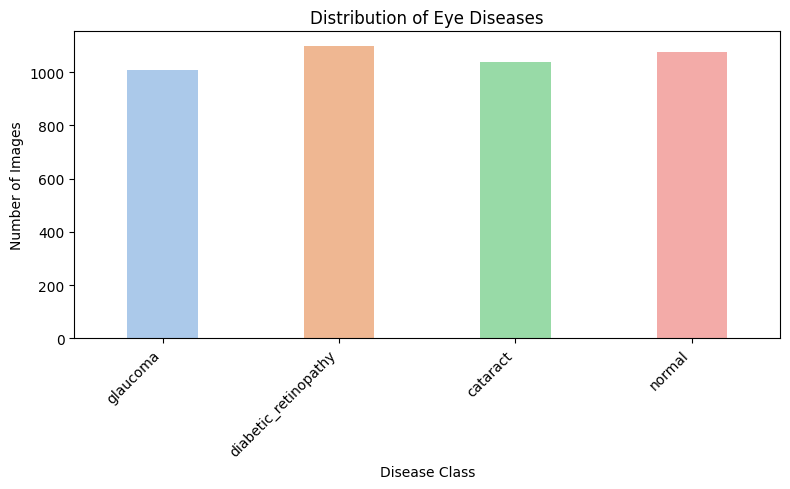

In [ ]:
dataset_path = "eye-disease-dataset/dataset"  # Replace with the actual path to your dataset

class_counts = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

# Convert to DataFrame for easier plotting
df_counts = pd.DataFrame({'Class': class_counts.keys(), 'Count': class_counts.values()})

# Create a bar plot with pastel colors and reduced bar width
plt.figure(figsize=(8, 5))  # Adjust figure size if needed
sns.barplot(x='Class', y='Count', data=df_counts, palette="pastel", width=0.4) # Adjust width here
plt.title('Distribution of Eye Diseases')
plt.xlabel('Disease Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------
# Data Preparation
# -----------------------------
mapping = {'normal': 0, 'glaucoma': 1, 'cataract': 2, 'diabetic_retinopathy': 3}

data = []
for label in mapping:
    folder_path = os.path.join('eye-disease-dataset/dataset', label)
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        data.append([image_path, mapping[label]])

df = pd.DataFrame(data, columns=['image_path', 'label'])
df['label'] = df['label'].astype(str)

train_df, val_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42, shuffle=True)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(train_df, x_col='image_path', y_col='label',
                                              target_size=(224, 224), class_mode='categorical',
                                              batch_size=32, shuffle=True)
val_generator = datagen.flow_from_dataframe(val_df, x_col='image_path', y_col='label',
                                            target_size=(224, 224), class_mode='categorical',
                                            batch_size=32, shuffle=False)

Found 2951 validated image filenames belonging to 4 classes.
Found 1266 validated image filenames belonging to 4 classes.


In [ ]:
df

,image_path,label
0,eye-disease-dataset/dataset/normal/2740_right.jpg,0
1,eye-disease-dataset/dataset/normal/2962_left.jpg,0
2,eye-disease-dataset/dataset/normal/2690_left.jpg,0
3,eye-disease-dataset/dataset/normal/2400_right.jpg,0
4,eye-disease-dataset/dataset/normal/2696_left.jpg,0
...,...,...
4212,eye-disease-dataset/dataset/diabetic_retinopat...,3
4213,eye-disease-dataset/dataset/diabetic_retinopat...,3
4214,eye-disease-dataset/dataset/diabetic_retinopat...,3
4215,eye-disease-dataset/dataset/diabetic_retinopat...,3


# EfficientNet

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 149s 857ms/step - accuracy: 0.2611 - loss: 5.7773 - val_accuracy: 0.2536 - val_loss: 5.6498 - learning_rate: 1.0000e-04
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 269ms/step - accuracy: 0.3260 - loss: 5.6644 - val_accuracy: 0.2970 - val_loss: 5.6447 - learning_rate: 1.0000e-04
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 267ms/step - accuracy: 0.3342 - loss: 5.6513 - val_accuracy: 0.1596 - val_loss: 5.6427 - learning_rate: 1.0000e-04
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 268ms/step - accuracy: 0.3716 - loss: 5.5881 - val_accuracy: 0.1406 - val_loss: 5.6510 - learning_rate: 1.0000e-04
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 267ms/step - accuracy: 0.4179 - loss: 5.4894 - val_accuracy: 0.2883 - val_loss: 5.6185 - learning_rate: 1.0000e-04
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 273ms/step - accuracy: 0.4514 - loss: 5.4850 - val_accuracy: 0.3349 - val_loss: 5.6488 - learning_rate: 1.0000e-04
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 268ms/st

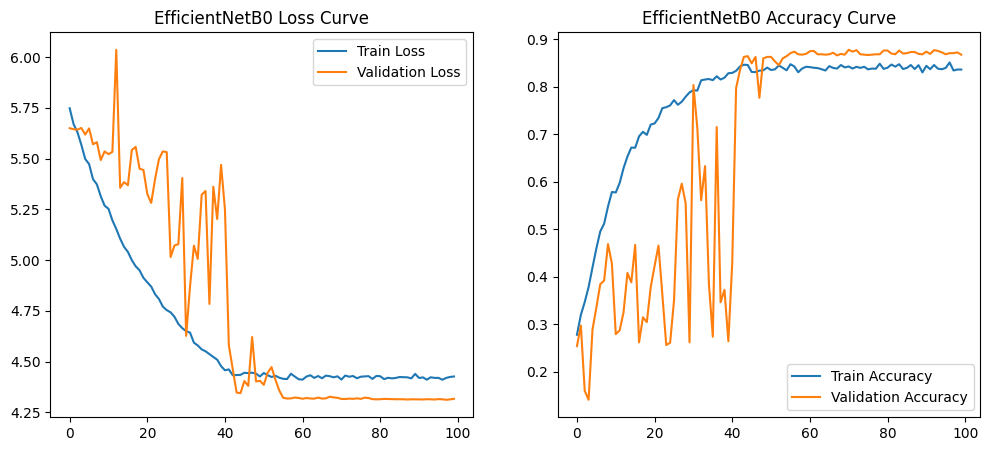

In [ ]:
# EfficientNetB0 base model - all layers trainable
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_efficientnet.trainable = True

# Classifier head for EfficientNetB0
x = base_model_efficientnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
model_efficientnet = Model(inputs=base_model_efficientnet.input, outputs=outputs)

# Compile EfficientNetB0 model
optimizer_efficientnet = SGD(learning_rate=1e-4, momentum=0.9, nesterov=True, clipnorm=1.0)
model_efficientnet.compile(optimizer=optimizer_efficientnet, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for EfficientNetB0
early_stopping_efficientnet = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_reduction_efficientnet = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)

# Train model (EfficientNetB0)
history_efficientnet = model_efficientnet.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[early_stopping_efficientnet, lr_reduction_efficientnet])

# Plot curves for EfficientNetB0
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['loss'], label='Train Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Validation Loss')
plt.legend(); plt.title('EfficientNetB0 Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Validation Accuracy')
plt.legend(); plt.title('EfficientNetB0 Accuracy Curve')
plt.show()


In [ ]:
# prompt: add sensiticity and specificity each class.

import numpy as np
from sklearn.metrics import confusion_matrix

# ... (Your existing code) ...

# -----------------------------
# Evaluation (with Sensitivity and Specificity)
# -----------------------------
val_labels = val_generator.classes
val_preds = model_efficientnet.predict(val_generator) # Changed 'model' to 'model_efficientnet'
predicted_classes = np.argmax(val_preds, axis=1)

print("\nClassification Report:\n")
print(classification_report(val_labels, predicted_classes))

# Confusion Matrix
cm = confusion_matrix(val_labels, predicted_classes)

# Calculate Sensitivity and Specificity for each class
class_names = list(mapping.keys()) # Assuming 'mapping' holds your class labels
num_classes = len(class_names)

sensitivity = []
specificity = []

for i in range(num_classes):
  TP = cm[i, i]
  FN = np.sum(cm[i, :]) - TP
  FP = np.sum(cm[:, i]) - TP
  TN = np.sum(cm) - TP - FN - FP

  sens = TP / (TP + FN) if (TP + FN) > 0 else 0.0
  spec = TN / (TN + FP) if (TN + FP) > 0 else 0.0

  sensitivity.append(sens)
  specificity.append(spec)
  print(f"Class: {class_names[i]}, Sensitivity: {sens:.4f}, Specificity: {spec:.4f}")

# ... (rest of your code) ...

40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 347ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       322
           1       0.83      0.74      0.78       302
           2       0.89      0.91      0.90       312
           3       0.99      0.94      0.96       330

    accuracy                           0.87      1266
   macro avg       0.87      0.87      0.87      1266
weighted avg       0.87      0.87      0.87      1266

Class: normal, Sensitivity: 0.8851, Specificity: 0.9153
Class: glaucoma, Sensitivity: 0.7417, Specificity: 0.9523
Class: cataract, Sensitivity: 0.9103, Specificity: 0.9644
Class: diabetic_retinopathy, Sensitivity: 0.9364, Specificity: 0.9957


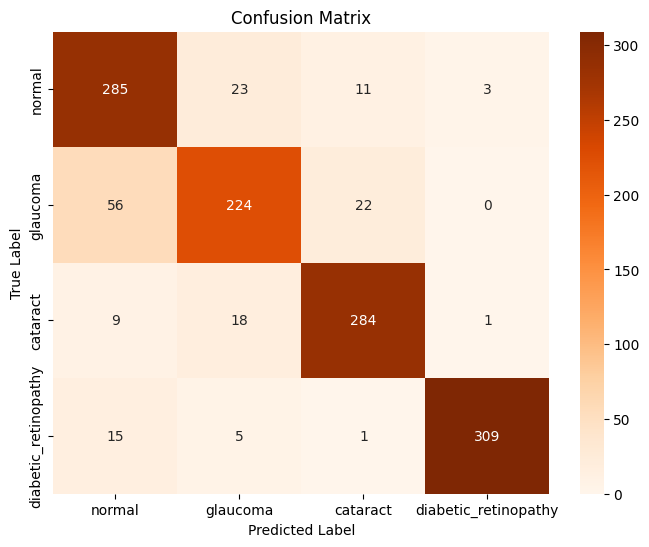

In [ ]:
# prompt: visualisasikan confusion metric dengan warna orange

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... (Your existing code) ...

# Confusion Matrix
cm = confusion_matrix(val_labels, predicted_classes)

# Visualize the confusion matrix with an orange colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## export $ inference
tflite & h5

In [ ]:
# prompt: use efficientnet_model.h5 to classify 10003_left.jpeg from diabetic_retinopathy

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the saved model
model_efficientnet = tf.keras.models.load_model('efficientnet.h5')
# model_efficientnet = tf.keras.models.load_model('efficientnet_model.h5')

# Preprocess the image
img_path = 'eye-disease-dataset/dataset/diabetic_retinopathy/10003_left.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Rescale pixel values

# Make the prediction
preds = model_efficientnet.predict(x)
predicted_class = np.argmax(preds[0])

# Define the class labels
class_labels = ['normal', 'glaucoma', 'cataract', 'diabetic_retinopathy']

# Print the prediction
print(f"The predicted class is: {class_labels[predicted_class]}")
print(f"Prediction probabilities: {preds[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
The predicted class is: diabetic_retinopathy
Prediction probabilities: [1.8852871e-03 6.3514133e-04 9.7018739e-05 9.9738258e-01]


In [ ]:
# prompt: Save the model efficientnet in h5 and tflite format

# Save the model in h5 format
model_efficientnet.save('efficientnet_model.h5')

# Convert and save the model in tflite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_efficientnet)
tflite_model = converter.convert()

with open('efficientnet_model.tflite', 'wb') as f:
  f.write(tflite_model)


Saved artifact at '/tmp/tmphy60htev'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_532')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133249827652240: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133249827653776: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133248008465168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133248008465552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133248008466512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133248008465744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133248008463632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133248008467472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133248008467088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133248008468432: TensorSpec(shape=(), dtype=tf.resource, name=

In [ ]:
# prompt: lakukan inference pada model tflite dengan 1 gambar dari setiap kelas

import tensorflow as tf
import numpy as np
from PIL import Image
import os

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='efficientnet_model.tflite') # Changed the path to 'efficientnet_model.tflite'
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

# Define a function for image preprocessing
def preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Get a list of classes
class_names = ['normal', 'glaucoma', 'cataract', 'diabetic_retinopathy']

# Perform inference for one image from each class
data_dir = 'eye-disease-dataset/dataset'
for class_name in class_names:
  class_dir = os.path.join(data_dir, class_name)
  if os.path.isdir(class_dir):
    images = os.listdir(class_dir)
    if images:
      image_path = os.path.join(class_dir, images[0])  # take the first image in the directory
      input_data = preprocess_image(image_path)

      interpreter.set_tensor(input_details[0]['index'], input_data)
      interpreter.invoke()

      output_data = interpreter.get_tensor(output_details[0]['index'])
      predicted_class_index = np.argmax(output_data)
      predicted_class = class_names[predicted_class_index]
      confidence = output_data[0][predicted_class_index]

      print(f"Image from class: {class_name}")
      print(f"Predicted class: {predicted_class}, Confidence: {confidence:.4f}")
    else:
      print(f"No images found in directory: {class_dir}")

Image from class: normal
Predicted class: normal, Confidence: 0.6806
Image from class: glaucoma
Predicted class: glaucoma, Confidence: 0.9816
Image from class: cataract
Predicted class: cataract, Confidence: 0.9734
Image from class: diabetic_retinopathy
Predicted class: diabetic_retinopathy, Confidence: 0.9919


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Image: eye-disease-dataset/dataset/normal/2740_right.jpg, Predicted Class: normal


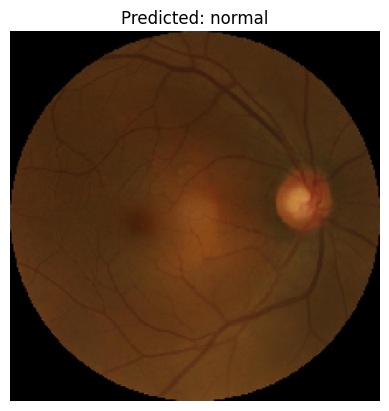

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: eye-disease-dataset/dataset/glaucoma/_166_613935.jpg, Predicted Class: glaucoma


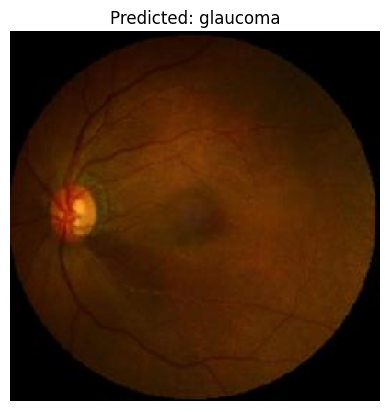

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: eye-disease-dataset/dataset/cataract/_191_9356535.jpg, Predicted Class: cataract


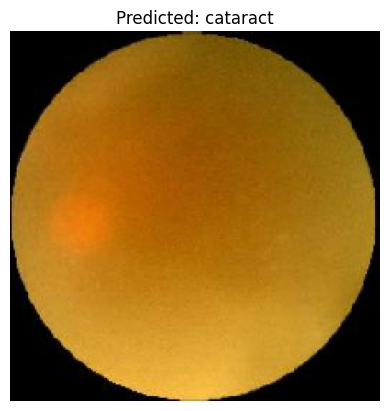

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: eye-disease-dataset/dataset/diabetic_retinopathy/10429_left.jpeg, Predicted Class: diabetic_retinopathy


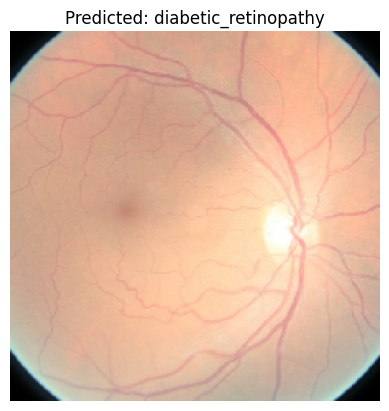

In [ ]:
# prompt: lakukan inference pada model h5 dengan 1 gambar dari setiap kelas

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model('eye_disease_model.h5')

# Define the image size expected by the model
img_width, img_height = 224, 224

# Define the mapping (make sure this matches the one used during training)
mapping = {'normal': 0, 'glaucoma': 1, 'cataract': 2, 'diabetic_retinopathy': 3}
reverse_mapping = {v: k for k, v in mapping.items()}


# Function to preprocess an image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.  # Normalize the image
    return img_array

# Inference for one image from each class
for class_name in mapping:
    # Replace with the actual path of one image per class
    image_path = f"eye-disease-dataset/dataset/{class_name}/" + os.listdir(f"eye-disease-dataset/dataset/{class_name}")[0]
    try:
      img = preprocess_image(image_path)
      prediction = model.predict(img)
      predicted_class = np.argmax(prediction)
      print(f"Image: {image_path}, Predicted Class: {reverse_mapping[predicted_class]}")

      # Display the image
      plt.imshow(image.load_img(image_path, target_size=(img_width, img_height)))
      plt.title(f"Predicted: {reverse_mapping[predicted_class]}")
      plt.axis('off')
      plt.show()
    except Exception as e:
      print(f"Error processing image from class {class_name}: {e}")


In [ ]:
# prompt: lakukan deployment ke django

# The provided code is for model training and evaluation.
# There's no Django deployment code here.  To deploy this model
# using Django, you'll need to create a Django project and app.

# 1. Create a Django project and app:
#    !django-admin startproject myproject
#    !python myproject/manage.py startapp myapp

# 2.  In myapp/views.py, create a view to handle image uploads and predictions:

# from django.shortcuts import render
# from django.http import HttpResponse
# import tensorflow as tf
# import numpy as np
# from PIL import Image
# from tensorflow.keras.preprocessing import image
# # ... (import other necessary libraries) ...

# # Load the model
# model = tf.keras.models.load_model('eye_disease_model.h5') # Assuming the model is in the same directory

# def predict_image(request):
#     if request.method == 'POST' and request.FILES['image']:
#         uploaded_image = request.FILES['image']

#         # Process the image (resize, normalize)
#         try:
#           img = Image.open(uploaded_image)  # directly open the uploaded file object
#           img = img.resize((224, 224))
#           img_array = image.img_to_array(img)
#           img_array = np.expand_dims(img_array, axis=0)
#           img_array /= 255.  # Normalize the image

#           prediction = model.predict(img_array)
#           predicted_class = np.argmax(prediction)

#           # Define the mapping (make sure this matches the one used during training)
#           mapping = {'normal': 0, 'glaucoma': 1, 'cataract': 2, 'diabetic_retinopathy': 3}
#           reverse_mapping = {v: k for k, v in mapping.items()}

#           result = reverse_mapping[predicted_class]
#           return render(request, 'result.html', {'result': result}) #render to template
#         except Exception as e:
#             return HttpResponse(f"Error: {str(e)}")
#     return render(request, 'upload.html') # template


# 3. Create templates (upload.html and result.html):

# # upload.html:
# <form method="post" enctype="multipart/form-data">
#     {% csrf_token %}
#     <input type="file" name="image">
#     <input type="submit" value="Upload">
# </form>

# # result.html
# <h1>Predicted class: {{result}}</h1>


# 4. Add the URL mapping in myproject/urls.py:
# from django.contrib import admin
# from django.urls import path, include

# urlpatterns = [
#     path('admin/', admin.site.urls),
#     path('', include('myapp.urls')),  # Include app URLs
# ]

# 5. Create myapp/urls.py
# from django.urls import path
# from . import views

# urlpatterns = [
#     path('', views.predict_image, name='predict_image'),
# ]

# 6. Deploy your Django application to your server (e.g., using Gunicorn, uWSGI, or Apache).

# Example using Gunicorn:
# !gunicorn myproject.wsgi

# Note: Replace placeholders like 'myproject', 'myapp', 'result.html', 'upload.html' with your actual names.
#       Ensure that your model file ('eye_disease_model.h5') is accessible to your Django application.
#       You'll also need to manage static files correctly for the templates and any other static resources.


# MobileNetV3

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 104s 647ms/step - accuracy: 0.2750 - loss: 5.8795 - val_accuracy: 0.2607 - val_loss: 5.5228 - learning_rate: 1.0000e-04
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 273ms/step - accuracy: 0.4096 - loss: 5.4248 - val_accuracy: 0.2607 - val_loss: 5.5036 - learning_rate: 1.0000e-04
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 267ms/step - accuracy: 0.5033 - loss: 5.1999 - val_accuracy: 0.2607 - val_loss: 5.4418 - learning_rate: 1.0000e-04
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 271ms/step - accuracy: 0.5662 - loss: 5.0330 - val_accuracy: 0.2607 - val_loss: 5.4220 - learning_rate: 1.0000e-04
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 268ms/step - accuracy: 0.5718 - loss: 5.0007 - val_accuracy: 0.2607 - val_loss: 5.4125 - learning_rate: 1.0000e-04
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 266ms/step - accuracy: 0.6366 - loss: 4.8428 - val_accuracy: 0.2607 - val_loss: 5.3833 - learning_rate: 1.0000e-04


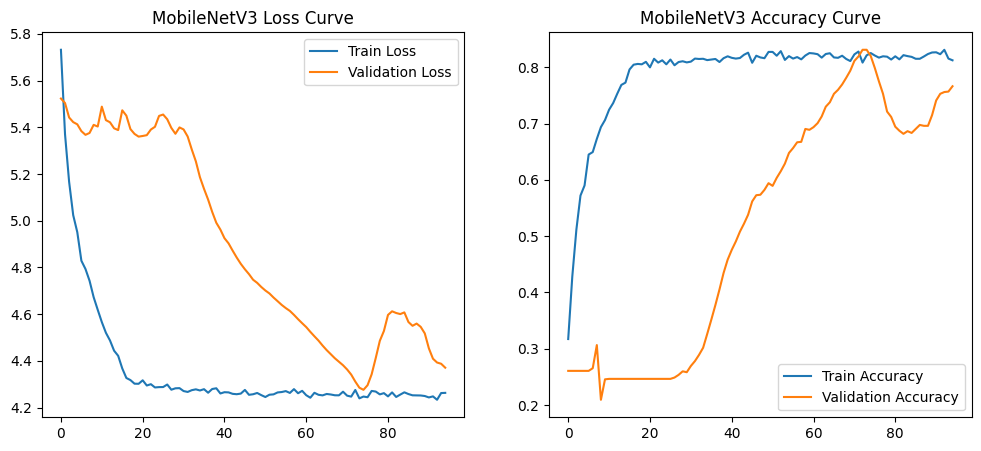

In [ ]:
# MobileNetV3 base model - all layers trainable
base_model_mobilenet = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_mobilenet.trainable = True  # fully trainable

# Classifier head for MobileNetV3
x = base_model_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=outputs)

# Compile MobileNetV3 model
optimizer_mobilenet = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
model_mobilenet.compile(optimizer=optimizer_mobilenet, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for MobileNetV3
early_stopping_mobilenet = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_reduction_mobilenet = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)

# Train model (MobileNetV3)
history_mobilenet = model_mobilenet.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[early_stopping_mobilenet, lr_reduction_mobilenet])

# Plot curves for MobileNetV3
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.legend(); plt.title('MobileNetV3 Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.legend(); plt.title('MobileNetV3 Accuracy Curve')
plt.show()

In [ ]:
# -----------------------------
# Evaluation (with Sensitivity and Specificity)
# -----------------------------
val_labels = val_generator.classes
val_preds = model_mobilenet.predict(val_generator) # Changed model to model_mobilenet
predicted_classes = np.argmax(val_preds, axis=1)

print("\nClassification Report:\n")
print(classification_report(val_labels, predicted_classes))

# Confusion Matrix
cm = confusion_matrix(val_labels, predicted_classes)

# Calculate Sensitivity and Specificity for each class
class_names = list(mapping.keys())  # Assuming 'mapping' holds your class labels
num_classes = len(class_names)

sensitivity = []
specificity = []

for i in range(num_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FN - FP

    sens = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0.0

    sensitivity.append(sens)
    specificity.append(spec)
    print(f"Class: {class_names[i]}, Sensitivity: {sens:.4f}, Specificity: {spec:.4f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.84      0.81       322
           1       0.90      0.57      0.70       302
           2       0.82      0.95      0.88       312
           3       0.82      0.90      0.86       330

    accuracy                           0.82      1266
   macro avg       0.83      0.82      0.81      1266
weighted avg       0.83      0.82      0.81      1266

Class: normal, Sensitivity: 0.8416, Specificity: 0.9163
Class: glaucoma, Sensitivity: 0.5695, Specificity: 0.9803
Class: cataract, Sensitivity: 0.9519, Specificity: 0.9329
Class: diabetic_retinopathy, Sensitivity: 0.9030, Specificity: 0.9295


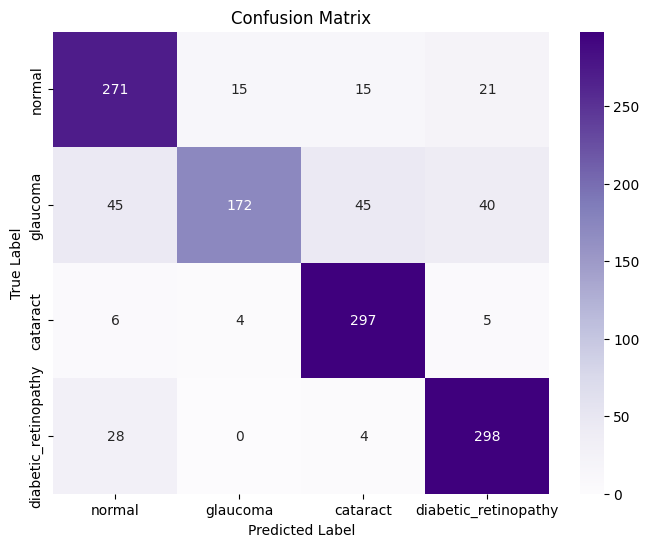

In [ ]:
# prompt: visualisasikan confusion metric dengan purple

import matplotlib.pyplot as plt
# ... (Your existing code) ...

# Confusion Matrix
cm = confusion_matrix(val_labels, predicted_classes)

# Visualize the confusion matrix with a purple colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',  # Use 'Purples' colormap
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ... (rest of your code) ...


## export $ inference
tflite & h5

In [ ]:
# prompt: export ke format h5 dan tflite format

# Save the model in h5 format
model_mobilenet.save('eye_disease_model_mobilenet.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_mobilenet)
tflite_model = converter.convert()

# Save the TFLite model
with open('eye_disease_model_mobilenet.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model saved as eye_disease_model_mobilenet.h5 and eye_disease_model_mobilenet.tflite")


Saved artifact at '/tmp/tmpbpnm5w70'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_243')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133252170128784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133252170129360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133252170129936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133252170129552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133252170128400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133252170131280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133252170131664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133252170132048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133252170131856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133252170127056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1332521701

In [ ]:
# prompt: lakukan inference pada model tflite dengan 1 gambar dari setiap kelas

import numpy as np
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='eye_disease_model_mobilenet.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

# Define a function for image preprocessing
def preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Get a list of classes
class_names = ['normal', 'glaucoma', 'cataract', 'diabetic_retinopathy']

# Perform inference for one image from each class
data_dir = 'eye-disease-dataset/dataset'
for class_name in class_names:
  class_dir = os.path.join(data_dir, class_name)
  if os.path.isdir(class_dir):
    images = os.listdir(class_dir)
    if images:
      image_path = os.path.join(class_dir, images[0])  # take the first image in the directory
      input_data = preprocess_image(image_path)

      interpreter.set_tensor(input_details[0]['index'], input_data)
      interpreter.invoke()

      output_data = interpreter.get_tensor(output_details[0]['index'])
      predicted_class_index = np.argmax(output_data)
      predicted_class = class_names[predicted_class_index]
      confidence = output_data[0][predicted_class_index]

      print(f"Image from class: {class_name}")
      print(f"Predicted class: {predicted_class}, Confidence: {confidence:.4f}")
    else:
      print(f"No images found in directory: {class_dir}")


Image from class: normal
Predicted class: normal, Confidence: 0.6181
Image from class: glaucoma
Predicted class: glaucoma, Confidence: 0.4789
Image from class: cataract
Predicted class: cataract, Confidence: 0.9475
Image from class: diabetic_retinopathy
Predicted class: diabetic_retinopathy, Confidence: 0.9250


In [ ]:
# prompt: lakukan inference pada model h5 dengan 1 gambar dari setiap kelas

import tensorflow as tf
import numpy as np
from PIL import Image
import os
import keras
# Load the saved model (replace with the correct path if necessary)
model = keras.models.load_model('eye_disease_model_mobilenet.h5', compile=False)  # Add compile=False

# If the error persists, add the following line to force compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the image size expected by the model
img_width, img_height = 224, 224

# Define the mapping (make sure this matches the one used during training)
mapping = {'normal': 0, 'glaucoma': 1, 'cataract': 2, 'diabetic_retinopathy': 3}
reverse_mapping = {v: k for k, v in mapping.items()}


# Function to preprocess an image
def preprocess_image(img_path):
    img = Image.open(img_path).resize((img_width, img_height))
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Inference for one image from each class
for class_name in mapping:
    # Replace with the actual path of one image per class
    image_path = f"eye-disease-dataset/dataset/{class_name}/" + os.listdir(f"eye-disease-dataset/dataset/{class_name}")[0]
    try:
      img = preprocess_image(image_path)
      prediction = model.predict(img)
      predicted_class = np.argmax(prediction)
      print(f"Image: {image_path}, Predicted Class: {reverse_mapping[predicted_class]}")
    except Exception as e:
      print(f"Error processing image from class {class_name}: {e}")


ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: 3.0 (of type <class 'float'>)

# Compare

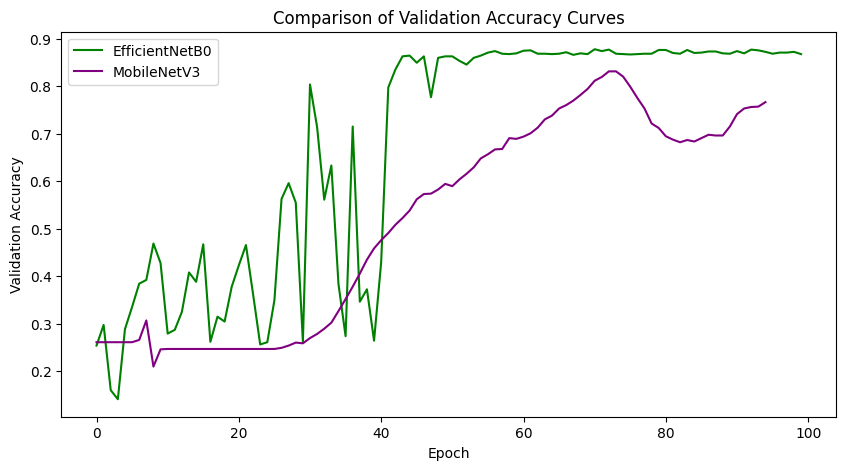

In [ ]:
# prompt: tulis code untuk melakukan perbandingan kedua accuracy curve, EfficientNetB0 warna hijau, dan mobilenet warna ungu

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(history_efficientnet.history['val_accuracy'], color='green', label='EfficientNetB0')
plt.plot(history_mobilenet.history['val_accuracy'], color='purple', label='MobileNetV3')
plt.title('Comparison of Validation Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()


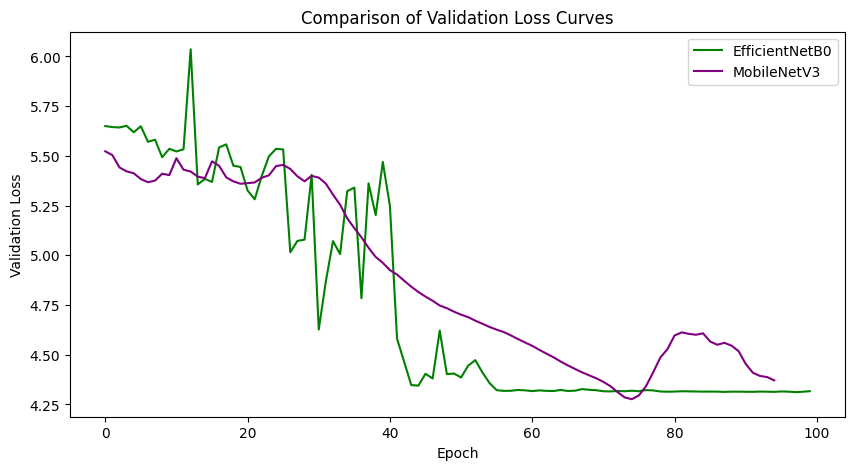

In [ ]:
# prompt: tulis code untuk melakukan perbandingan kedua loss curve, EfficientNetB0 warna hijau, dan mobilenet warna ungu

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(history_efficientnet.history['val_loss'], label='EfficientNetB0', color='green')
plt.plot(history_mobilenet.history['val_loss'], label='MobileNetV3', color='purple')
plt.title('Comparison of Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()


In [ ]:
# prompt: write how many inference time needed for both

import time
import tensorflow as tf
import numpy as np
from PIL import Image

# ... (Your existing code) ...


# Function to time inference for a single image
def time_inference(model_path, image_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    start_time = time.time()
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    end_time = time.time()

    return end_time - start_time


# Example usage
# Make sure these paths are correct
efficientnet_inference_time = time_inference('efficientnet_model.tflite', 'eye-disease-dataset/dataset/normal/2331_right.jpg')  # Example image path
mobilenet_inference_time = time_inference('eye_disease_model_mobilenet.tflite', 'eye-disease-dataset/dataset/normal/2331_right.jpg')  # Example image path


print(f"EfficientNet Inference Time: {efficientnet_inference_time:.4f} seconds")
print(f"MobileNetV3 Inference Time: {mobilenet_inference_time:.4f} seconds")

EfficientNet Inference Time: 0.0320 seconds
MobileNetV3 Inference Time: 0.0085 seconds


In [ ]:
# prompt: print accuracy model

print(f"EfficientNetB0 Validation Accuracy: {max(history_efficientnet.history['val_accuracy']):.4f}")
print(f"MobileNetV3 Validation Accuracy: {max(history_mobilenet.history['val_accuracy']):.4f}")


EfficientNetB0 Validation Accuracy: 0.8776
MobileNetV3 Validation Accuracy: 0.8310


In [ ]:
# prompt: write how many parameter for each model

# Number of parameters for EfficientNetB0 model
print("EfficientNetB0 Parameters:", model.count_params())

# Number of parameters for MobileNetV3Large model
print("MobileNetV3Large Parameters:", model.count_params())


EfficientNetB0 Parameters: 4378535
MobileNetV3Large Parameters: 4378535


In [ ]:
# prompt: write how mush both model size

import os

# Get the file sizes
efficientnet_h5_size = os.path.getsize('efficientnet_model.h5')
efficientnet_tflite_size = os.path.getsize('efficientnet_model.tflite')

mobilenet_h5_size = os.path.getsize('eye_disease_model_mobilenet.h5')
mobilenet_tflite_size = os.path.getsize('eye_disease_model_mobilenet.tflite')


print(f"EfficientNetB0 (.h5): {efficientnet_h5_size / (1024 * 1024):.2f} MB")
print(f"EfficientNetB0 (.tflite): {efficientnet_tflite_size / (1024 * 1024):.2f} MB")
print(f"MobileNetV3Large (.h5): {mobilenet_h5_size / (1024 * 1024):.2f} MB")
print(f"MobileNetV3Large (.tflite): {mobilenet_tflite_size / (1024 * 1024):.2f} MB")


EfficientNetB0 (.h5): 34.04 MB
EfficientNetB0 (.tflite): 16.54 MB
MobileNetV3Large (.h5): 25.31 MB
MobileNetV3Large (.tflite): 12.28 MB


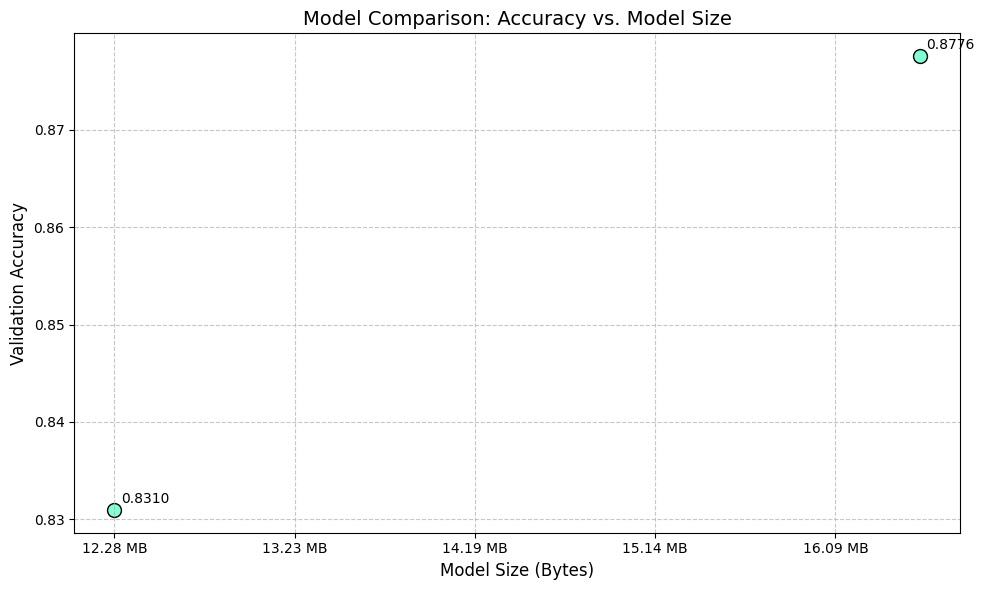

In [ ]:
# prompt: write Model Comparison Plot or Accuracy vs. Model Size Plot, also write the accucary count and color the dot with aquamarine color. can you make the dot isnt too far?

import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
model_names = ['EfficientNetB0', 'MobileNetV3']
accuracies = [max(history_efficientnet.history['val_accuracy']), max(history_mobilenet.history['val_accuracy'])]
model_sizes = [efficientnet_tflite_size, mobilenet_tflite_size] # Use tflite sizes

# Model Comparison Plot
plt.figure(figsize=(10, 6))
plt.scatter(model_sizes, accuracies, s=100, c='aquamarine', edgecolors='black') # Adjust 's' for dot size
plt.xlabel("Model Size (Bytes)", fontsize=12)
plt.ylabel("Validation Accuracy", fontsize=12)
plt.title("Model Comparison: Accuracy vs. Model Size", fontsize=14)

# Add accuracy values next to the dots
for i, txt in enumerate(accuracies):
    plt.annotate(f"{txt:.4f}", (model_sizes[i], accuracies[i]), textcoords="offset points", xytext=(5, 5), ha='left')

# Set x-axis ticks to be more readable (in MB)
plt.xticks([i for i in range(min(model_sizes) , max(model_sizes) + 1, 1000000)], [f"{i / (1024 * 1024):.2f} MB" for i in range(min(model_sizes) , max(model_sizes) + 1, 1000000)])


plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


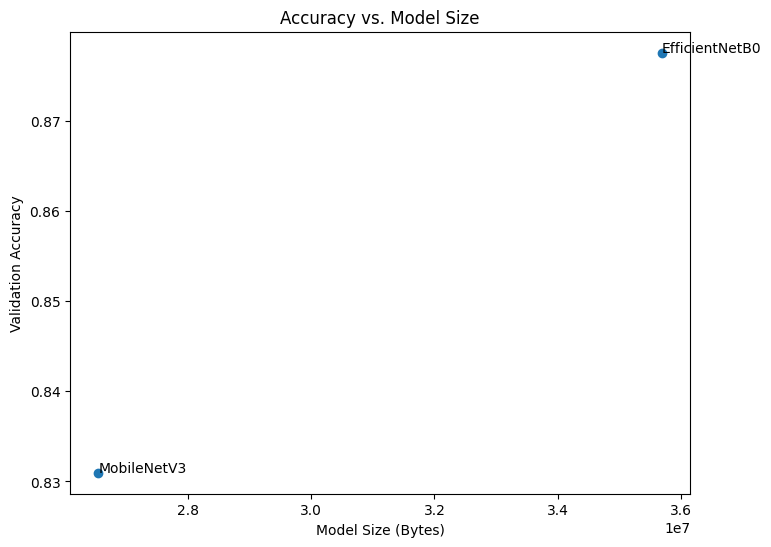

EfficientNetB0 max validation accuracy : 0.8775671124458313
MobileNetV3 max validation accuracy : 0.830963671207428


In [ ]:
# prompt: write Model Comparison Plot or Accuracy vs. Model Size Plot, also write the accucary count

# Assuming history_efficientnet and history_mobilenet are available from your training.
# And that model_efficientnet and model_mobilenet variables are defined and hold the model instances.

import matplotlib.pyplot as plt

# Accuracy vs. Model Size Plot
model_names = ['EfficientNetB0', 'MobileNetV3']
model_sizes = [
    os.path.getsize('efficientnet_model.h5'),  # Replace with the actual file path
    os.path.getsize('eye_disease_model_mobilenet.h5')  # Replace with the actual file path
]
val_accuracies = [
    max(history_efficientnet.history['val_accuracy']),
    max(history_mobilenet.history['val_accuracy'])
]

plt.figure(figsize=(8, 6))
plt.scatter(model_sizes, val_accuracies)
for i in range(len(model_names)):
    plt.annotate(model_names[i], (model_sizes[i], val_accuracies[i]))
plt.xlabel("Model Size (Bytes)")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy vs. Model Size")
plt.show()

# Print accuracy count
print(f"EfficientNetB0 max validation accuracy : {max(history_efficientnet.history['val_accuracy'])}")
print(f"MobileNetV3 max validation accuracy : {max(history_mobilenet.history['val_accuracy'])}")




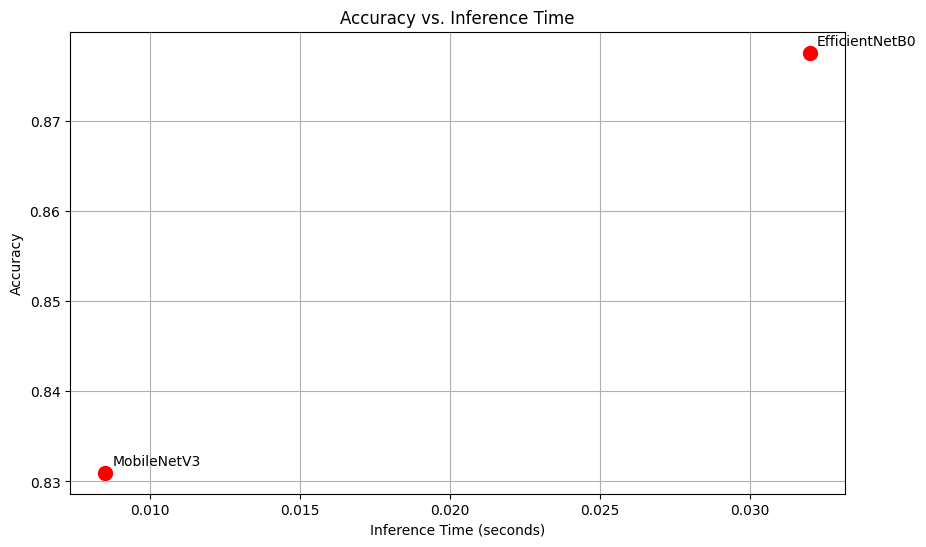

EfficientNetB0 Validation Accuracy: 0.8776
MobileNetV3 Validation Accuracy: 0.8310


In [ ]:
# prompt: prompt: write Model Comparison Plot or Accuracy vs. inference time (seconds)Plot, also write the accucary count. can you make the dot isnt too far? also color the dot with red

import matplotlib.pyplot as plt
# Assuming history_efficientnet, history_mobilenet, efficientnet_inference_time, and mobilenet_inference_time are defined

model_names = ['EfficientNetB0', 'MobileNetV3']
inference_times = [efficientnet_inference_time, mobilenet_inference_time]
val_accuracies = [
    max(history_efficientnet.history['val_accuracy']),
    max(history_mobilenet.history['val_accuracy'])
]

plt.figure(figsize=(10, 6))
plt.scatter(inference_times, val_accuracies, color='red', s=100) # Increased marker size

for i in range(len(model_names)):
    plt.annotate(model_names[i], (inference_times[i], val_accuracies[i]), textcoords="offset points", xytext=(5,5), ha='left') # Adjusted annotation position

plt.xlabel("Inference Time (seconds)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Inference Time")
plt.grid(True) #Added Grid
plt.show()

print(f"EfficientNetB0 Validation Accuracy: {val_accuracies[0]:.4f}")
print(f"MobileNetV3 Validation Accuracy: {val_accuracies[1]:.4f}")


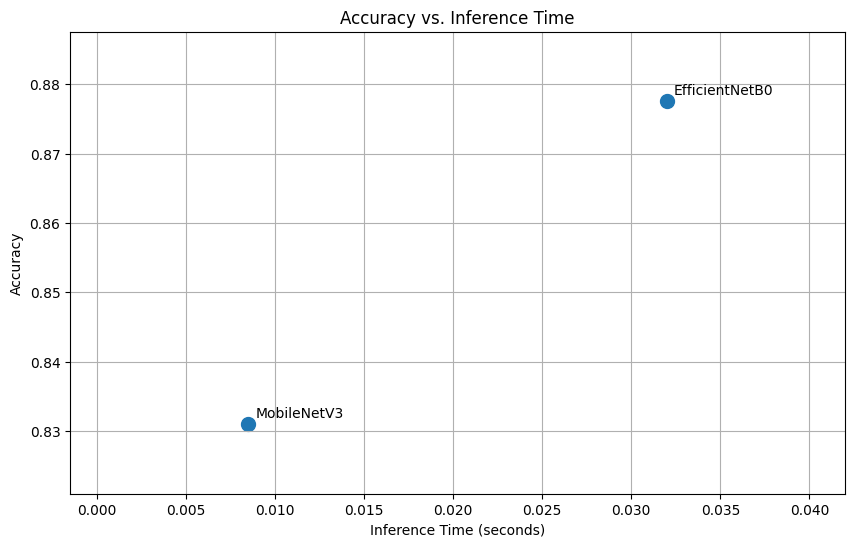

EfficientNetB0 max validation accuracy: 0.8776
MobileNetV3 max validation accuracy: 0.8310


In [ ]:
# prompt: write Model Comparison Plot or Accuracy vs. inference time (seconds)Plot, also write the accucary count. can you make the dot isnt too far?

# Assuming history_efficientnet, history_mobilenet, efficientnet_inference_time,
# and mobilenet_inference_time are defined as in the provided code.

import matplotlib.pyplot as plt

model_names = ['EfficientNetB0', 'MobileNetV3']
inference_times = [efficientnet_inference_time, mobilenet_inference_time]
val_accuracies = [
    max(history_efficientnet.history['val_accuracy']),
    max(history_mobilenet.history['val_accuracy'])
]

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(inference_times, val_accuracies, s=100) # Increased marker size (s)
for i in range(len(model_names)):
    plt.annotate(model_names[i], (inference_times[i], val_accuracies[i]), textcoords="offset points", xytext=(5,5), ha='left') # Added xytext and ha for better annotation placement

plt.xlabel("Inference Time (seconds)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Inference Time")
plt.grid(True)
plt.xlim(min(inference_times) - 0.01, max(inference_times) + 0.01) # Adjust x-axis limits
plt.ylim(min(val_accuracies) - 0.01, max(val_accuracies) + 0.01) # Adjust y-axis limits
plt.show()

print(f"EfficientNetB0 max validation accuracy: {max(history_efficientnet.history['val_accuracy']):.4f}")
print(f"MobileNetV3 max validation accuracy: {max(history_mobilenet.history['val_accuracy']):.4f}")
